In [1]:
from enum import Enum, auto
import networkx as nx
from networkx.generators.classic import complete_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.utils.decorators import py_random_state
from math import floor, ceil
import numpy as np
from random import choices, sample, random
import matplotlib.pyplot as plt

N_NODES = 934
K = 10
BETA = 0.3
RHO = 0.6
DK = 1
DBETA = 0.1
DRHO = 0.1
N_WEEKS = 15
N = 50
VACC = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60] # first index is initial state
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

class State(Enum):
    # enum type for representing SIR states
    SUSCEPTIBLE = auto()
    INFECTED = auto()
    RECOVERED = auto()
    VACCINATED = auto()
    
class RandomGraph:
    
    def __init__(self, k):
        """
        creates an initial complete graph of size k+1
        """
        self.k = k
        self.graph = nx.complete_graph(k+1)
        
    def grow(self, n_iterations):
            
        for i in range(n_iterations):
            new_node = len(self.graph) # node numeration starts at 0
            nodes_link_added = set()
            n_edges_to_add = floor(self.k/2) if i % 2 == 0 else ceil(self.k/2)
            
            for _ in range(n_edges_to_add):
                distrib = np.array([d if n not in nodes_link_added else 0 for n,d in self.graph.degree])
                distrib = distrib / sum(distrib)
                node_to_link = choices(range(len(self.graph)), weights = distrib ,k=1)[0]
                nodes_link_added.add(node_to_link)
                    
                    
            self.graph.add_node(new_node)
            self.graph.add_edges_from([(new_node, node) for node in nodes_link_added])
            

def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

@py_random_state("seed")
def random_graph(n, k, seed=None):
    """
    we are going to use a modified implementation of networkx, for quickness reasons(see explanation at the end)
    the only modification is changing the number of edges added ( allowing for an odd degree)
    https://networkx.org/documentation/stable/_modules/networkx/generators/random_graphs.html#barabasi_albert_graph
    """
    G = nx.complete_graph(k+1)
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    source = len(G)
    
    while source < n:
        m = floor(k/2) if source % 2 == 0 else ceil(k/2)
        targets = _random_subset(repeated_nodes, m, seed)
        G.add_edges_from(zip([source] * m, targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)
        source += 1
    return G
            
        
class Simulation:
    def __init__(self, network, initially_vaccinated, initially_infected=None):
        """
        if initially_infected and initially_vaccinated overlap, vaccination has the advantage
        """
        self.network = network # should be RandomGraph underlying graph
        self.weeks = []
        self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
        if initially_infected is None:
            initially_infected = sample(range(N_NODES), k=10)       
        for node in initially_infected:
            self.weeks[0][node] = State.INFECTED # self.weeks[0] represents initial state
        for node in initially_vaccinated:
            self.weeks[0][node] = State.VACCINATED
            
    def simulate(self, n_weeks=N_WEEKS, beta=BETA, rho=RHO):
        for time in range(1,n_weeks+1):
            self.weeks.append([State.SUSCEPTIBLE]*N_NODES)
            for node in range(N_NODES):
                old_state = self.weeks[time-1][node]
                if old_state == State.SUSCEPTIBLE:
                    m = [self.weeks[time-1][neigh] for neigh in self.network.neighbors(node)].count(State.INFECTED)
                    new_state = State.INFECTED if random() < 1 - (1-beta)**m else State.SUSCEPTIBLE
                    self.weeks[time][node] = new_state
                elif old_state == State.INFECTED:
                    new_state = State.RECOVERED if random() < rho else State.INFECTED
                    self.weeks[time][node] = new_state
                else:
                    self.weeks[time][node] = self.weeks[time-1][node]
                    
            ## VACCINATION
            vacc_rate = (VACC[time] - VACC[time-1])/100
            n_people_to_vaccinate = int(N_NODES * vacc_rate)
            people_to_vaccinate = sample(
                [node for node in range(N_NODES) if self.weeks[time][node] != State.VACCINATED],
                    k=n_people_to_vaccinate)
            for node in people_to_vaccinate:
                self.weeks[time][node] = State.VACCINATED

In [2]:
def gradient_step(k0, beta0, rho0, dk, dbeta, drho, with_fixed_k = False):
    # can go wrong if beta or rho not \in [0, 1]
    ks = [k0-dk, k0, k0+dk] if not with_fixed_k else [k0]
    betas = [beta0 - dbeta, beta0, beta0 + dbeta]
    rhos = [rho0 - drho, rho0, rho0 + drho]
    results = {}
    
    print("Beginning of the gradient step")
    print("Initial parameters (k, beta, rho):", k0, beta0, rho0)
    print("With step (dk, dbeta, drho) :", dk, dbeta, drho)
    print("")
    
    
    for k in ks:
        for beta in betas:
            for rho in rhos:
                
                # generate a random graph of average degree k
                
                
                infec = []
                for _ in range(N):
                    
                    
                    g = random_graph(N_NODES, k)
                        
                    # we resample a new first invected at each simulation
                    # for avoiding bias from chosen node
                    initially_infected = sample(range(N_NODES), k=1) # there's a single infection at the beginning
                    vaccination_candidates = [node for node in range(N_NODES) if node != initially_infected[0]]
                    initially_vaccinated = sample(vaccination_candidates, k = int(VACC[0]* N_NODES / 100)  )  
                    s = Simulation(g, initially_vaccinated, initially_infected)
                    s.simulate(beta=beta, rho=rho)
                    weeks = s.weeks
                    infec.append([len([node for node in range(N_NODES) if weeks[time-1][node]==State.SUSCEPTIBLE and weeks[time][node]==State.INFECTED]) for time in range(1,len(weeks))])
                
                infec = np.array(infec)
                I = np.mean(infec, axis = 0)
                score = RMSE(I)
                    
                results[(k, beta, rho)] = score
                
    best_params = min(results, key = lambda k : results[k])
                
    print("End of the gradient step")
    print("Best parameters (k, beta, rho):", best_params)
    print("With RMSE =", results[best_params])
    print("\n\n")  
    
    return best_params
    
    
def RMSE(I):
    # we compute RMSE beginning from week 1
    return np.sqrt(np.sum((I-I0[1:])**2)/N_WEEKS)

In [3]:
def gradient_search(k0 = K, beta0 = BETA, rho0 = RHO, dk = DK, dbeta = DBETA, drho = DRHO, with_fixed_k=False):
    old_k, old_beta, old_rho = k0, beta0, rho0
    (new_k, new_beta, new_rho) = gradient_step(old_k, old_beta, old_rho, dk, dbeta, drho)
    while not all(np.isclose((old_k, old_beta, old_rho), (new_k, new_beta, new_rho))):
        old_k, old_beta, old_rho = new_k, new_beta, new_rho
        (new_k, new_beta, new_rho) = gradient_step(old_k, old_beta, old_rho, dk, dbeta, drho, with_fixed_k)
    return (new_k, new_beta, new_rho)

In [4]:
def check_simulation(best_k, best_beta, best_rho):
    n_simulations = 100
    infec = []

    for _ in range(n_simulations):
        network = random_graph(N_NODES, best_k)
        initially_infected = sample(range(N_NODES), k=1)
        vaccination_candidates = [node for node in range(N_NODES) if node != initially_infected[0]]
        initially_vaccinated = sample(vaccination_candidates, k = int(VACC[0]* N_NODES / 100)  )  
        s = Simulation(network, initially_vaccinated, initially_infected)
        s.simulate(beta=best_beta, rho=best_rho)
        weeks = s.weeks
        infec.append([len([node for node in range(N_NODES) if weeks[time-1][node]==State.SUSCEPTIBLE and weeks[time][node]==State.INFECTED]) for time in range(1,len(weeks))])

    infec = np.array(infec)
    I = np.mean(infec, axis=0)

    fig = plt.figure(1, figsize=(7,7))
    ax = plt.subplot(111)

    ax.plot(range(1, N_WEEKS+1), I, label='Simulated infected nodes')
    ax.plot(range(1, N_WEEKS+1), I0[1:], label='Truly infected nodes')

    plt.title("Comparison of simulation of number of infected people and actual number infected people")
    plt.xlabel("Time in weeks")
    plt.ylabel("Number of nodes")

    ax.legend()
    print("RMSE :", RMSE(I))

Beginning of the gradient step
Initial parameters (k, beta, rho): 10 0.3 0.6
With step (dk, dbeta, drho) : 1 0.1 0.1

End of the gradient step
Best parameters (k, beta, rho): (9, 0.19999999999999998, 0.6)
With RMSE = 5.998877672809583



Beginning of the gradient step
Initial parameters (k, beta, rho): 9 0.19999999999999998 0.6
With step (dk, dbeta, drho) : 1 0.1 0.1

End of the gradient step
Best parameters (k, beta, rho): (9, 0.19999999999999998, 0.6)
With RMSE = 6.129019497440027



RMSE : 10.245415885490774


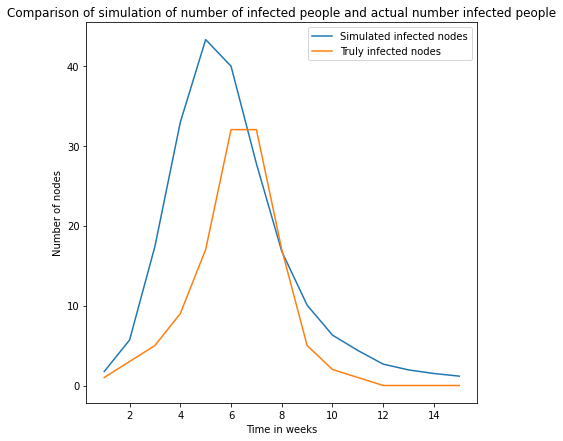

In [5]:
(best_k, best_beta, best_rho) = gradient_search()
check_simulation(best_k, best_beta, best_rho)

Beginning of the gradient step
Initial parameters (k, beta, rho): 9 0.19999999999999998 0.6
With step (dk, dbeta, drho) : 1 0.05 0.05

End of the gradient step
Best parameters (k, beta, rho): (10, 0.14999999999999997, 0.5499999999999999)
With RMSE = 5.23553244665717



Beginning of the gradient step
Initial parameters (k, beta, rho): 10 0.14999999999999997 0.5499999999999999
With step (dk, dbeta, drho) : 1 0.05 0.05

End of the gradient step
Best parameters (k, beta, rho): (10, 0.14999999999999997, 0.49999999999999994)
With RMSE = 5.692851658000584



Beginning of the gradient step
Initial parameters (k, beta, rho): 10 0.14999999999999997 0.49999999999999994
With step (dk, dbeta, drho) : 1 0.05 0.05

End of the gradient step
Best parameters (k, beta, rho): (9, 0.14999999999999997, 0.44999999999999996)
With RMSE = 5.510431320081336



Beginning of the gradient step
Initial parameters (k, beta, rho): 9 0.14999999999999997 0.44999999999999996
With step (dk, dbeta, drho) : 1 0.05 0.05

End

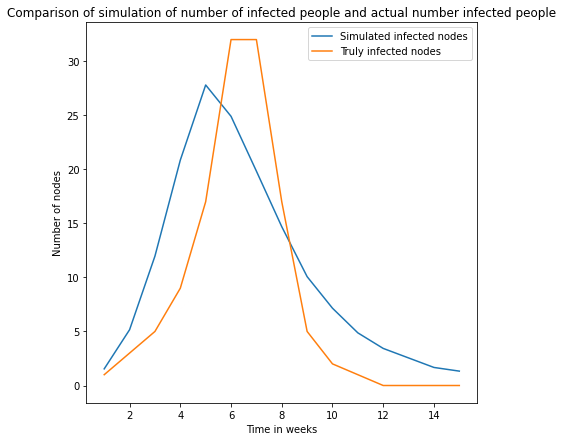

In [6]:
DK, DBETA, DRHO = DK, DBETA/2, DRHO/2
(best_k, best_beta, best_rho) = gradient_search(best_k, best_beta, best_rho, DK, DBETA, DRHO)
check_simulation(best_k, best_beta, best_rho)

Beginning of the gradient step
Initial parameters (k, beta, rho): 7 0.19999999999999996 0.39999999999999997
With step (dk, dbeta, drho) : 1 0.025 0.025

End of the gradient step
Best parameters (k, beta, rho): (7, 0.19999999999999996, 0.39999999999999997)
With RMSE = 5.476906669523104



RMSE : 6.168050475366319


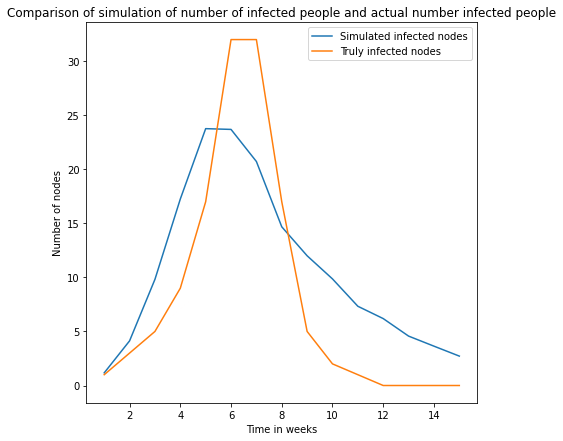

In [7]:
DBETA, DRHO = DBETA/2, DRHO/2
(best_k, best_beta, best_rho) = gradient_search(best_k, best_beta, best_rho, DK, DBETA, DRHO)
check_simulation(best_k, best_beta, best_rho)

Beginning of the gradient step
Initial parameters (k, beta, rho): 7 0.19999999999999996 0.39999999999999997
With step (dk, dbeta, drho) : 1 0.0125 0.0125

End of the gradient step
Best parameters (k, beta, rho): (8, 0.18749999999999994, 0.38749999999999996)
With RMSE = 5.489976320531811



Beginning of the gradient step
Initial parameters (k, beta, rho): 8 0.18749999999999994 0.38749999999999996
With step (dk, dbeta, drho) : 1 0.0125 0.0125

End of the gradient step
Best parameters (k, beta, rho): (7, 0.19999999999999996, 0.37499999999999994)
With RMSE = 5.230253021285554



Beginning of the gradient step
Initial parameters (k, beta, rho): 7 0.19999999999999996 0.37499999999999994
With step (dk, dbeta, drho) : 1 0.0125 0.0125

End of the gradient step
Best parameters (k, beta, rho): (7, 0.19999999999999996, 0.38749999999999996)
With RMSE = 5.501384068274698



Beginning of the gradient step
Initial parameters (k, beta, rho): 7 0.19999999999999996 0.38749999999999996
With step (dk, dbet

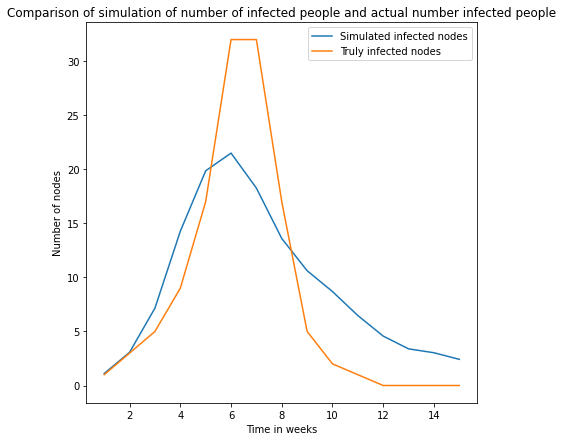

In [8]:
DBETA, DRHO = DBETA/2, DRHO/2
(best_k, best_beta, best_rho) = gradient_search(best_k, best_beta, best_rho, DK, DBETA, DRHO)
check_simulation(best_k, best_beta, best_rho)

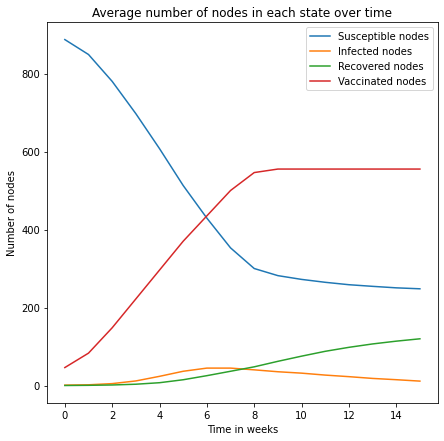

In [10]:
susc, infec, recov, vacc = [], [], [], []

for _ in range(N):
    g = random_graph(N_NODES, best_k)
    initially_infected = sample(range(N_NODES), k=1)
    vaccination_candidates = [node for node in range(N_NODES) if node != initially_infected[0]]
    initially_vaccinated = sample(vaccination_candidates, k = int(VACC[0]* N_NODES / 100)  )  
    s = Simulation(g, initially_vaccinated, initially_infected)
    s.simulate(beta=best_beta, rho=best_rho)
    weeks = s.weeks
    susc.append([weeks[time].count(State.SUSCEPTIBLE) for time in range(len(weeks))])
    infec.append([weeks[time].count(State.INFECTED) for time in range(len(weeks))])
    recov.append([weeks[time].count(State.RECOVERED) for time in range(len(weeks))])
    vacc.append([weeks[time].count(State.VACCINATED) for time in range(len(weeks))])
    
susc, infec, recov, vacc = np.array(susc), np.array(infec), np.array(recov), np.array(vacc)

fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)
ax.plot(np.mean(susc, axis=0), label='Susceptible nodes')
ax.plot(np.mean(infec, axis=0), label='Infected nodes')
ax.plot(np.mean(recov, axis=0), label='Recovered nodes')
ax.plot(np.mean(vacc, axis=0), label='Vaccinated nodes')
plt.title("Average number of nodes in each state over time")
plt.xlabel("Time in weeks")
plt.ylabel("Number of nodes")

ax.legend()

In [11]:
import timeit
from networkx.generators.random_graphs import barabasi_albert_graph
timeit.timeit(lambda : barabasi_albert_graph(N_NODES, K, initial_graph=nx.complete_graph(K+1)), number=1)

0.02658413399967685

In [12]:
timeit.timeit(lambda : RandomGraph(K).grow(N_NODES-(K+1)), number=1)

1.4794009850002112

In [13]:
timeit.timeit(lambda : random_graph(N_NODES, K), number=1)

0.014839899000435253

In [14]:
G = random_graph(N_NODES, 11)
print(np.mean([d for n,d in G.degree]))

11.0
